### Шаг 1. Загрузка данных и подготовка их к анализу

In [1]:
# импорт библиотек
import pandas as pd
import seaborn as sns 
from matplotlib import pyplot as plt 
from plotly import graph_objects as go
import plotly.express as px
from io import BytesIO
import requests 
pd.set_option('display.float_format', '{:,.2f}'.format)
pd.set_option('max_rows', 77)

In [2]:
# чтение файла с данными и сохранение в hypothesis 
try:
    rest_data = pd.read_csv('/datasets/rest_data.csv')
except FileNotFoundError:
    print('файл или директория не существует!')

In [3]:
dict_df = {'Объекты общественного питания': rest_data} 

In [4]:
# функция получения информации
def get_info(name, df): 
    

    print('\033[1m' + 'Первые 5 строк таблицы: ' + name + '\033[0m')
    display(df.head())
    print()
    print('\033[1m' + 'Сводная информация о таблице: ' + name + '\033[0m')
    print()
    df.info()
    print()
    print('\033[1m' + 'Описательная статистика таблицы: ' + name + '\033[0m')
    display(df.describe())
    print()
    print('\033[1m' + 'Описательная статистика таблицы: ' + name + '\033[0m')
    display(df.describe(include=[object]))
    print()
    print('\033[1m' + 'Пропуски в таблице: ' + name + '\033[0m')
    report = df.isna().sum().to_frame()
    report = report.rename(columns = {0: 'missing_values'})
    report['% of total'] = (100 * report['missing_values'] / df.shape[0]).round(2)
    display(report.sort_values(by = 'missing_values', ascending = False))
    print()

In [5]:
# получаем информацию по таблицам
for dfd in dict_df:
    get_info(dfd, dict_df[dfd])

Первые 5 строк таблицы: Объекты общественного питания


,id,object_name,chain,object_type,address,number
0,151635,СМЕТАНА,нет,кафе,"город Москва, улица Егора Абакумова, дом 9",48
1,77874,Родник,нет,кафе,"город Москва, улица Талалихина, дом 2/1, корпус 1",35
2,24309,Кафе «Академия»,нет,кафе,"город Москва, Абельмановская улица, дом 6",95
3,21894,ПИЦЦЕТОРИЯ,да,кафе,"город Москва, Абрамцевская улица, дом 1",40
4,119365,Кафе «Вишневая метель»,нет,кафе,"город Москва, Абрамцевская улица, дом 9, корпус 1",50



Сводная информация о таблице: Объекты общественного питания

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15366 entries, 0 to 15365
Data columns (total 6 columns):
id             15366 non-null int64
object_name    15366 non-null object
chain          15366 non-null object
object_type    15366 non-null object
address        15366 non-null object
number         15366 non-null int64
dtypes: int64(2), object(4)
memory usage: 720.4+ KB

Описательная статистика таблицы: Объекты общественного питания


,id,number
count,"15,366.00","15,366.00"
mean,"119,720.07",59.55
std,"73,036.13",74.74
min,838.00,0.00
25%,"28,524.00",12.00
50%,"144,974.50",40.00
75%,"184,262.25",80.00
max,"223,439.00","1,700.00"



Описательная статистика таблицы: Объекты общественного питания


,object_name,chain,object_type,address
count,15366,15366,15366,15366
unique,10393,2,9,9108
top,Столовая,нет,кафе,"город Москва, Ходынский бульвар, дом 4"
freq,267,12398,6099,95



Пропуски в таблице: Объекты общественного питания


,missing_values,% of total
id,0,0.00
object_name,0,0.00
chain,0,0.00
object_type,0,0.00
address,0,0.00
number,0,0.00


In [6]:
# выводим на экран сетевые заведения с одним заведением 
group_name = (
    rest_data.query('chain == "да"')
    .groupby('object_name').agg({'id': 'count', 'number' : 'mean'})
    .query('id == 1')
) 
group_name

,id,number
object_name,,
Beverly Hills Diner,1,88.00
Bierloga,1,75.00
Black & White,1,40.00
BooBo,1,46.00
Bubbleology,1,6.00
...,...,...
кафе «Нияма»,1,80.00
кафе «Папа Джонс»,1,24.00
кафе «Шоколадница»,1,50.00


В названиях заведений присутствуют слова кафе, ресторан, пицца, итд. Удалим их из названий.

In [7]:
rest_data['object_name'] = rest_data['object_name'].str.lower() # приводим названия заведений к нижнему регистру

In [8]:
# создаём список слов которые будем удалять из названий
str_er = (
    ['ресторан ', 'кафе ', '«', '»', 'предприятие быстрого обслуживания ', ' пицца', 'пиццерия ', ' кофе', '.', 
     'быстрого питания ', 'при ', 'закусочная ', 'бар ', 'паб ', 'сеть магазинов ', 'предприятие ']
) 

In [9]:
# создаём цикл удаляющий ненужные слова
for  i in str_er:
    rest_data['object_name'] = [s.replace(i, '') for s in rest_data['object_name']]

### Шаг 2. Анализ данных

#### Исследуйте соотношение видов объектов общественного питания по количеству. Постройте график.

In [10]:
# группируем rest_data по виду объектов общественного питания, сортируем по количеству объектов 
group_object_count = (
    rest_data.groupby('object_type').agg({'id': 'count'})
    .sort_values(by = 'id', ascending = False)
    .rename(columns={'id': 'count'})
)
group_object_count

,count
object_type,
кафе,6099
столовая,2587
ресторан,2285
предприятие быстрого обслуживания,1923
бар,856
буфет,585
кафетерий,398
закусочная,360
магазин (отдел кулинарии),273


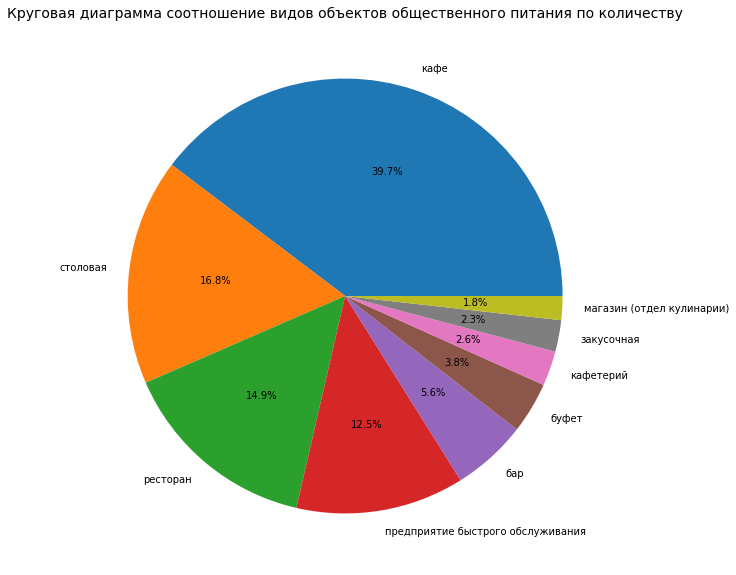

In [11]:
# строим круговую диаграмму соотношение видов объектов общественного питания по количеству
pie, ax = plt.subplots(figsize=[10, 10])
labels = group_object_count.index
plt.pie(x = group_object_count['count'], autopct="%.1f%%", labels=labels)
plt.title("Круговая диаграмма соотношение видов объектов общественного питания по количеству", fontsize=14)
plt.show()

Кафе занимают 39.7% от всех заведений общественного питания.

#### Исследуйте соотношение сетевых и несетевых заведений по количеству. Постройте график.

In [12]:
# группируем rest_data по сетевым и не сетевым объектам общественного питания, сортируем по количеству объектов 
group_chain = (
    rest_data.groupby('chain').agg({'id': 'count'})
    .sort_values(by = 'id', ascending = False)
    .rename(columns={'id': 'count'})
)
group_chain

,count
chain,
нет,12398
да,2968


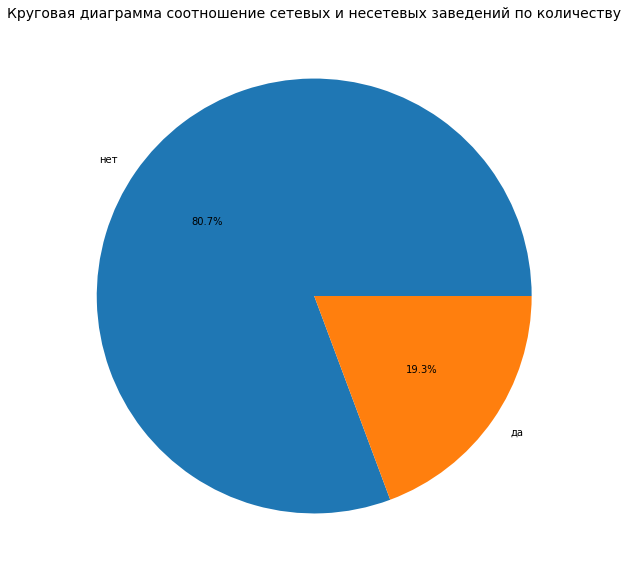

In [13]:
# строим круговую диаграмму соотношение сетевых и несетевых заведений по количеству
pie, ax = plt.subplots(figsize=[10, 10])
labels = group_chain.index
plt.pie(x = group_chain['count'], autopct="%.1f%%", labels=labels)
plt.title("Круговая диаграмма соотношение сетевых и несетевых заведений по количеству", fontsize=14)
plt.show()

Сетевых заведений всего 19.3%

#### Для какого вида объекта общественного питания характерно сетевое распространение?

In [14]:
group_object = rest_data.query('chain == "да"').groupby('object_type').agg({'id': 'count'}) # группировка по типу объектов сетевых
group_object = group_object.merge(rest_data.groupby('object_type').agg({'id': 'count'}), on = 'object_type') # объединение датафреймов group_object и rest_data  
group_object['%'] = round((group_object['id_x']/group_object['id_y']*100),1) # расчет процентов
group_object[['%']].sort_values(by = '%', ascending = False) # сортировка по процентам

,%
object_type,
предприятие быстрого обслуживания,41.10
магазин (отдел кулинарии),28.60
ресторан,23.80
кафе,22.90
закусочная,15.60
кафетерий,13.10
бар,4.30
буфет,1.90
столовая,0.10


Cетевыми чаще всего оказываются предприятия предприятие быстрого обслуживания 41.1%

#### Что характерно для сетевых заведений: много заведений с небольшим числом посадочных мест в каждом или мало заведений с большим количеством посадочных мест?

In [15]:
# группируем по названию заведения сетевых объектов
group_name = (
    rest_data.query('chain == "да"')
    .groupby('object_name').agg({'id': 'count', 'number' : 'mean'})
    .sort_values(by = 'id', ascending = False)
)

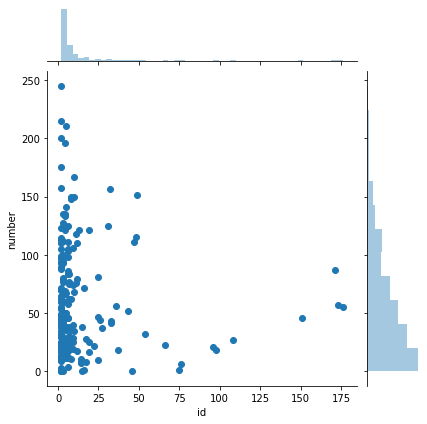

In [16]:
# строим график зависимости количества посадочных мест от количества заведений
sns.jointplot(x = 'id', y = 'number', data = group_name.query('id != 1'))
plt.show()

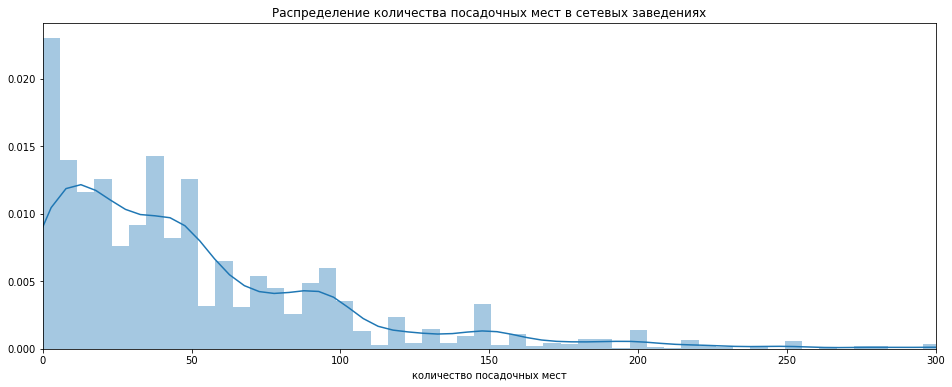

In [17]:
plt.figure(figsize=(16, 6))
plt.title('Распределение количества посадочных мест в сетевых заведениях')
sns.distplot(rest_data.query('chain == "да"')['number'], bins=100)
plt.xlim(0, 300)
plt.xlabel('количество посадочных мест')
plt.show()

В Москве для сетевых заведений характерно мало заведений с небольшим числом посадочных мест в каждом.

#### Для каждого вида объекта общественного питания опишите среднее количество посадочных мест. Какой вид предоставляет в среднем самое большое количество посадочных мест? Постройте графики.

In [18]:
# группируем по типу заведений
group_object = (
    rest_data.groupby('object_type', as_index=False).agg({'number' : 'mean'})
    .rename(columns={'number': 'avg_number'})
    .sort_values(by = 'avg_number', ascending = False)
)

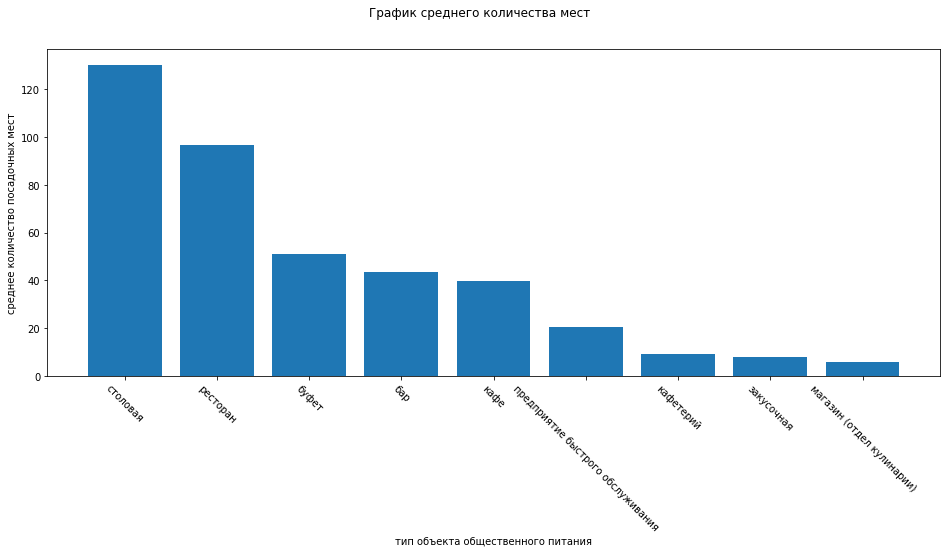

In [19]:
# строим график среднего количества мест
fig = plt.figure(figsize=(16, 6))
plt.bar(group_object['object_type'], group_object['avg_number'])
fig.suptitle('График среднего количества мест')
plt.xticks(rotation = -45)
plt.ylabel('среднее количество посадочных мест')
plt.xlabel('тип объекта общественного питания')
#fig.savefig('test.jpg')
plt.show()

В столовых среднее количество мест самое большое.

#### Выделите в отдельный столбец информацию об улице из столбца address.

In [20]:
# выделяем из столбца address информацию об улице
rest_data['street'] = rest_data['address'].apply(lambda x: x.split(', дом')[0]) 
rest_data['street'] = rest_data['street'].apply(lambda x: x.split(', строение')[0])
#rest_data['street'] = rest_data['street'].apply(lambda x: x.split(', корпус')[0])
#rest_data['street'] = rest_data['street'].apply(lambda x: x.split(', владение')[0])
rest_data['street'] = rest_data['street'].apply(lambda x: x.split(',')[-1])
rest_data['street'] = [s.replace(' Московской Кольцевой Автодороги', '') for s in rest_data['street']]
rest_data['street'] = rest_data['street'].str.strip()

rest_data.head(10)

,id,object_name,chain,object_type,address,number,street
0,151635,сметана,нет,кафе,"город Москва, улица Егора Абакумова, дом 9",48,улица Егора Абакумова
1,77874,родник,нет,кафе,"город Москва, улица Талалихина, дом 2/1, корпус 1",35,улица Талалихина
2,24309,академия,нет,кафе,"город Москва, Абельмановская улица, дом 6",95,Абельмановская улица
3,21894,пиццетория,да,кафе,"город Москва, Абрамцевская улица, дом 1",40,Абрамцевская улица
4,119365,вишневая метель,нет,кафе,"город Москва, Абрамцевская улица, дом 9, корпус 1",50,Абрамцевская улица
5,27429,стол гоу сош № 1051,нет,столовая,"город Москва, Абрамцевская улица, дом 15, корп...",240,Абрамцевская улица
6,148815,брусника,да,кафе,"город Москва, переулок Сивцев Вражек, дом 6/2",10,переулок Сивцев Вражек
7,20957,буфет мтуси,нет,столовая,"город Москва, Авиамоторная улица, дом 8, строе...",90,Авиамоторная улица
8,20958,кпф семья-1,нет,столовая,"город Москва, Авиамоторная улица, дом 8, строе...",150,Авиамоторная улица
9,28858,столовая мтуси,нет,столовая,"город Москва, Авиамоторная улица, дом 8, строе...",120,Авиамоторная улица


#### Постройте график топ-10 улиц по количеству объектов общественного питания. Воспользуйтесь внешней информацией и ответьте на вопрос — в каких районах Москвы находятся эти улицы?

In [21]:
# группируем по улице и сортируем в порядке убывания колтчества объектов
top = (
    rest_data.groupby('street', as_index=False).agg({'id': 'count'})
    .sort_values(by = 'id', ascending = False)
    .rename(columns={'id': 'count'})
)
top_10 = top.head(10)

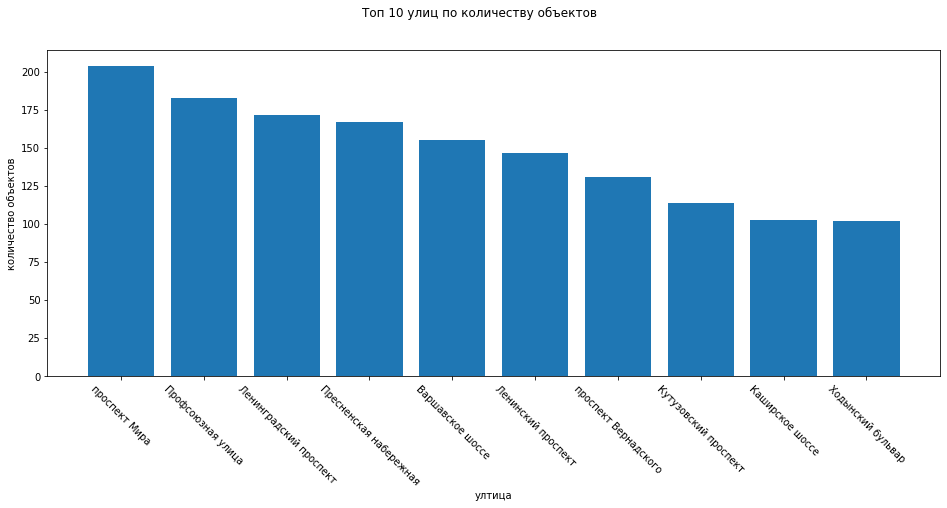

In [22]:
# строим график топ 10 улиц по количеству объектов общественного питания
fig = plt.figure(figsize=(16, 6))
plt.bar(top_10['street'], top_10['count'])
fig.suptitle('Топ 10 улиц по количеству объектов')
plt.xticks(rotation = -45)
plt.ylabel('количество объектов')
plt.xlabel('ултица')
#fig.savefig('test.jpg')
plt.show()

Больше всего заведений общественного питания на проспекте Мира.

In [23]:
# экспортируем таблицу с улицами и районами Москвы и сохраним в street_districts
spredsheet_id = '1nSyd373vP3xot9SeSApujoP6oFwkb3-n8fFklGV4OFU'
file_name = 'https://docs.google.com/spreadsheets/d/{}/export?format=csv'.format(spredsheet_id)
r = requests.get(file_name)
street_districts = pd.read_csv(BytesIO(r.content))
street_districts['street'] = [s.replace('МКАД, ', '') for s in street_districts['street']]

In [24]:
top_10 = top_10.merge(street_districts, on='street',  how='left') # объединим таблицы top_10 и street_districts

In [25]:
print('Пропусков с столбце area:', top_10['area'].isna().sum())

Пропусков с столбце area: 0


In [26]:
top_10['area'].unique() # выведем на экран уникальные названия районов

array(['Алексеевский район', 'Ярославский Район', 'Район Марьина роща',
       'Останкинский район', 'Район Ростокино', 'Район Свиблово',
       'Мещанский район', 'Академический район', 'Район Черемушки',
       'Район Ясенево', 'Район Коньково', 'Обручевский район',
       'Район Теплый Стан', 'Район Аэропорт', 'Район Беговой',
       'Хорошевский район', 'Район Сокол', 'Пресненский район',
       'Район Чертаново Центральное', 'Район Чертаново Северное',
       'Район Чертаново Южное', 'Донской район',
       'Район Нагатино-Садовники', 'Нагорный район',
       'Район Северное Бутово', 'Район Южное Бутово',
       'Район Проспект Вернадского', 'Район Тропарево-Никулино',
       'Район Гагаринский', 'Ломоносовский район', 'Район Якиманка',
       'Район Раменки', 'Район Дорогомилово', 'Район Фили-Давыдково',
       'Район Москворечье-Сабурово', 'Район Орехово-Борисово Южное',
       'Район Орехово-Борисово Северное'], dtype=object)

#### Найдите число улиц с одним объектом общественного питания. Воспользуйтесь внешней информацией и ответьте на вопрос — в каких районах Москвы находятся эти улицы?

In [28]:
top_one_rest = top.query('count == 1') # найдём все улицы на которых всего один объект общественного питания и сохраним top_one_rest

In [29]:
top_one_rest = top_one_rest.merge(street_districts, on='street',  how='left') # объединим таблицы top_one_rest и street_districts

In [30]:
print('Пропусков с столбце area:', top_one_rest['area'].isna().sum())

Пропусков с столбце area: 218


In [31]:
top_one_rest[top_one_rest['area'].isna()]

,street,count,areaid,okrug,area
11,39-й километр Калужского шоссе,1,nan,NaN,NaN
12,улица Капотня,1,nan,NaN,NaN
24,43-й километр МКАД,1,nan,NaN,NaN
38,улица Корнея Чуковского,1,nan,NaN,NaN
80,Молодежная улица,1,nan,NaN,NaN
...,...,...,...,...,...
788,корпус 834В,1,nan,NaN,NaN
789,корпус 844,1,nan,NaN,NaN
790,корпус 855,1,nan,NaN,NaN
791,корпус 864,1,nan,NaN,NaN


In [35]:
rest_data.query('street == "корпус 834В"')

,id,object_name,chain,object_type,address,number,street
12457,198974,брашна,нет,кафе,"город Москва, город Зеленоград, корпус 834В",45,корпус 834В


In [32]:
top_one_rest['area'].unique() # выведем на экран уникальные названия районов

array(['Нагорный район', 'Южнопортовый Район', 'Район Лианозово',
       'Рязанский район', 'Савеловский район', 'Район Южное Бутово',
       'Район Южное Тушино', 'Район Лефортово', 'Район Хамовники',
       'Тимирязевский Район', 'Район Ново-Переделкино', nan,
       'Район Северный', 'Район Строгино', 'Район Чертаново Южное',
       'Район Сокольники', 'Район Марьина роща', 'Можайский Район',
       'Район Богородское', 'Тверской район', 'Красносельский район',
       'Район Москворечье-Сабурово', 'Даниловский район',
       'Район Отрадное', 'Район Замоскворечье', 'Район Печатники',
       'Таганский район', 'Панфиловский район', 'Пресненский район',
       'Район Арбат', 'Район Кунцево', 'Алексеевский район',
       'Мещанский район', 'Район Преображенское', 'Район Соколиная Гора',
       'Район Фили-Давыдково', 'Головинский район', 'Район Ясенево',
       'Район Гагаринский', 'Район Якиманка', 'Район Крюково',
       'Район Щукино', 'Бескудниковский Район', 'Басманный район',
   

#### Посмотрите на распределение количества посадочных мест для улиц с большим количеством объектов общественного питания. Какие закономерности можно выявить?

In [33]:
street_top_10 = top_10['street'].unique() # создади список улиц топ 10
street_top_10

array(['проспект Мира', 'Профсоюзная улица', 'Ленинградский проспект',
       'Пресненская набережная', 'Варшавское шоссе', 'Ленинский проспект',
       'проспект Вернадского', 'Кутузовский проспект', 'Каширское шоссе',
       'Ходынский бульвар'], dtype=object)

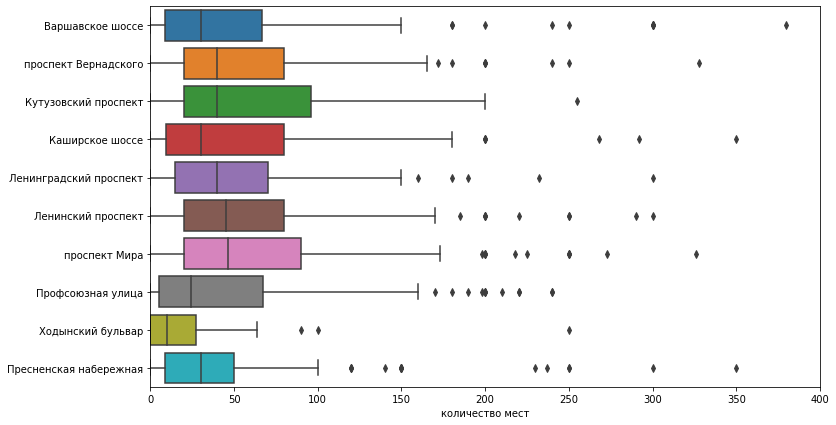

In [34]:
# строим распределение количества посадочных мест топ-10 улиц
rest_data_top_10 = rest_data.query('street in @street_top_10')
plt.figure(figsize=(12, 7))
plt.xlim(0,400)
#plt.title('Распределение количества посадочных мест топ-10 улиц')
sns.boxplot(x="number", y="street", data=rest_data_top_10, orient='h') 
plt.xlabel('количество мест')
plt.ylabel('')
plt.show()

Большинство заведений на улицах топ 10 вмещают не более 50 человек.

#### Вывод

При анализ рынка заведений общественного питания Москвы было обнаружено:
1. Кафе самое распространенное заведение общественного питания.
2. Пятая часть заведений общественного питания в Москве сетевые.
3. Cетевыми чаще всего оказываются предприятия быстрого обслуживания. 
4. В Москве для сетевых заведений характерно мало заведений с небольшим числом посадочных мест в каждом.
5. Больше всего посадочных мест в столовых.
6. Больше всего заведений общественного питания находится на больших улицах и проспектах.
7. Большинство заведений на улицах топ 10 вмещают не более 50 человек.
8. В датасете встречаются дубликаты при определенных комбинациях столбцов например на территории МГТУ им. Н. Э. Баумана, это большой университет с большим количеством столовых и буфетов.

    Если открывать одно заведение, то лучше открывать кафе с количеством посадочных мест до 50 человек. Если открывать сеть, то лучше открывать предприятие быстрого питания с количеством посадочных мест до 20 человек.  Лучшие места проспект Мира, Профсоюзная улица и Ленинградский проспект. 